# TOF Sensor Data Analysis

## Objective

The objective of this notebook is to analyze the effectiveness of WaveShare's Time of Flight (TOF) sensor at measuring distance, and draw conclusions from the data measured.

## Overview

I conducted 3 tiers of testing and data collection:

1. **Basic Tests**: The goal of this level of testing was to determine the accuracy of the TOF sensor in a controlled environment.
2. **Simple Outdoors Tests**: After setting up the sensor on a bicycle, the next level of testing involved riding past stationary objects and determining the accuracy of the data collected, and how effective the sensor was as a binary object detector.
3. **Cycling Tests**: The final level of testing involved using the sensor to measure the distances of cars overtaking the cyclist. The goal of this project is to ultimately collect data on this subject.

In [1]:
import datetime
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

## Basic Tests

* The first object is to determine the distance measuring capabilities of the TOF Sensor.
* I placed the sensor at intervals of 0.5 meters, from 0.5 meters to 5.0 meters, and allowed it to measure the distance for 500 points using the Windows software provided by WaveShare.
* I then take the average of the distances measured at each interval, and compare it to the **acutal** distance.

### Documentation on the Accuracy

* The documentation stated that the accuracy of the TOF sensor would be affected by natural light.
* Furthermore, it gave an estimate of the accuracy and standard deviation depending on the distances measured:

||Short Range (0 to 2.16m)|Mid Range (2.16 to 3.60 m)|Long Range (> 3.60m)|
|---|---|---|---|
|Accuracy|±1.0cm|±1.0cm|±1.5cm|
|Standard Deviation|0.3cm|1.5cm|8cm|

In [50]:
def get_mean(data: list[int]) -> float:
    """
    Return the mean of a list of data.

    Args:
        data (list[int]): The list of data.

    Returns:
        float: The mean rounded to 2 decimal places.
    """
    return round(np.mean(data), 2)


def get_data_from_excel_file(file_path: pathlib.Path) -> list[int]:
    """
    Get the first 500 points from the excel file.

    Args:
        file_path (pathlib.Path): The path to the excel file.

    Returns:
        list[int]: The first 500 points from the excel file.
    """
    return list(pd.read_excel(file_path)["distance(m)"][:500])


def get_data_from_folder(folder_path: pathlib.Path) -> list[list[int]]:
    """
    Get the first 500 points from each excel file in the folder.

    Args:
        folder_path (pathlib.Path): The path to the folder.

    Returns:
        list[list[int]]: Return an array containing a list for each of the first 500 
                         points from each excel file in the folder.
    """
    data = []
    for file_path in folder_path.iterdir():
        if file_path.suffix == ".xlsx":
            data.append(get_data_from_excel_file(file_path))
    return data


def get_mean_measurements(folder_path: pathlib.Path) -> list[float]:
    """
    Get the mean of the first 500 points from each excel file in the folder.

    Args:
        folder_path (pathlib.Path): The path to the folder.

    Returns:
        list[float]: Return an array containing the mean of the first 500 points from 
                     each excel file in the folder, in ascending order.
    """
    data = get_data_from_folder(folder_path)
    return sorted([get_mean(i) for i in data])

### TOF Sensor is Affected by Natural Light

- I first tested the sensor in an outdoors condition in bright afternoon sunlight and immediately realized that the accuracy of the sensor was affected by the natural light.

,0,1,2,3,4,5,6,7,8,9
Actual Distance,0.5,1.0,1.50,2.00,2.5,3.00,3.50,4.00,4.50,5.00
Measured Mean,0.5,1.0,1.54,2.11,2.6,2.96,2.96,3.28,3.32,3.33


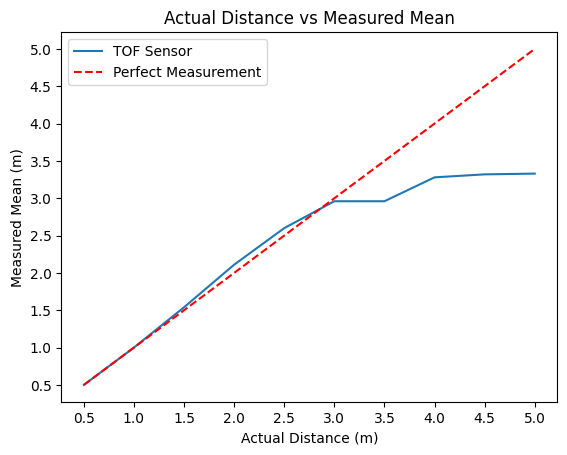

In [76]:
ACTUAL_DISTANCES = [0.5 * i for i in range(1, 11)]
outdoors_data_mean = get_mean_measurements(pathlib.Path("./data/outdoors"))
data = {
    "Actual Distance": ACTUAL_DISTANCES,
    "Measured Mean": outdoors_data_mean
}

df = pd.DataFrame.from_dict(data)
display(df.T)

df.plot(x="Actual Distance",
        y="Measured Mean",
        title="Actual Distance vs Measured Mean",
        xticks=ACTUAL_DISTANCES,
        yticks=ACTUAL_DISTANCES,
        xlabel="Actual Distance (m)",
        ylabel="Measured Mean (m)",)
plt.plot(ACTUAL_DISTANCES, ACTUAL_DISTANCES, color="red", linestyle="dashed")
plt.legend(["TOF Sensor", "Perfect Measurement"])

plt.show()